# Pregunta 2: Análisis de Opiniones sobre Películas

## a) Construcción y descripción del dataframe

In [1]:
import urllib
import pandas as pd

#train_data_url = "http://www.inf.utfsm.cl/~jnancu/stanford-subset/polarity.train"
#test_data_url = "http://www.inf.utfsm.cl/~jnancu/stanford-subset/polarity.dev"
#train_data_f = urllib.urlretrieve(train_data_url, "train_data.csv")
#test_data_f = urllib.urlretrieve(test_data_url, "test_data.csv")

ftr = open("train_data.csv", "r")
fts = open("test_data.csv", "r")
rows = [line.split(" ",1) for line in ftr.readlines()]
train_df = pd.DataFrame(rows, columns=['Sentiment','Text'])
train_df['Sentiment'] = pd.to_numeric(train_df['Sentiment'])
rows = [line.split(" ",1) for line in fts.readlines()]
test_df = pd.DataFrame(rows, columns=['Sentiment','Text'])
test_df['Sentiment'] = pd.to_numeric(test_df['Sentiment'])

print train_df.shape[0]
print test_df.shape[0]

3554
3554


In [2]:
from IPython.display import HTML, display

n_neg_train = train_df[train_df.Sentiment == -1].count().Sentiment
n_pos_train = train_df[train_df.Sentiment == 1].count().Sentiment

n_neg_test = test_df[test_df.Sentiment == -1].count().Sentiment
n_pos_test = test_df[test_df.Sentiment == 1].count().Sentiment

data = [['','Train','Test'],
        ['Positivo',n_pos_train,n_pos_test],
        ['Negativo',n_neg_train,n_neg_test],
        ['Total',n_pos_train+n_neg_train,n_pos_test+n_neg_test]
       ]

display(HTML(
        '<table><tr>{}</tr></table>'.format(
            '</tr><tr>'.join(
                '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
        )
    ))

,Train,Test
Positivo,1770,1751
Negativo,1784,1803
Total,3554,3554


Los datos corresponden a comentarios de películas las cuales pueden tener una etiqueta positiva (+1) o negativa (-1).

En total hay 3554 registros de entrenamiento y de prueba. La distribución de los datos según clase se encuentra en la tabla anterior.

## b) Word Extractor: Stemming

In [3]:
import re, time
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer, word_tokenize
from nltk.stem.porter import PorterStemmer

def word_extractor_stem(text, stopwords_filter=True):
    stemmer = PorterStemmer()
    commonwords = stopwords.words('english')
    text = re.sub(r'([a-z])\1+', r'\1\1',text)#substitute multiple letter by two
    words = ""
    wordtokens = [ stemmer.stem(word.lower()) \
                  for word in word_tokenize(text.decode('utf-8', 'ignore')) ]
    
    for word in wordtokens:
        if stopwords_filter:
            if word not in commonwords:
                words+=" "+word
        else:
            words+=" "+word
        
    return words

def word_extractor(text):
    stemmer = PorterStemmer()
    commonwords = stopwords.words('english')
    text = re.sub(r'([a-z])\1+', r'\1\1',text)#substitute multiple letter by two
    words = ""
    wordtokens = [ word.lower() \
                  for word in word_tokenize(text.decode('utf-8', 'ignore')) ]
    
    for word in wordtokens:
        if word not in commonwords:
            words+=" "+word

    return words

## c) Word Extractor: Lemmatization

In [4]:
def word_extractor_lemm(text, stopwords_filter=True):
    wordlemmatizer = WordNetLemmatizer()
    commonwords = stopwords.words('english')
    text = re.sub(r'([a-z])\1+', r'\1\1',text)#substitute multiple letter by two
    words = ""
    wordtokens = [ wordlemmatizer.lemmatize(word.lower()) \
                  for word in word_tokenize(text.decode('utf-8','ignore')) ]
    
    for word in wordtokens:
        if stopwords_filter:
            if word not in commonwords:
                words+=" "+word
        else:
            words+=" "+word
    
    return words

In [5]:
print "NORMAL"
print word_extractor("I love to eat cake")
print word_extractor("I love eating cake")
print word_extractor("I loved eating the cake")
print word_extractor("I do not love eating cake")
print word_extractor("I don't love eating cake")
print "STEMMING"
print word_extractor_stem("I love to eat cake")
print word_extractor_stem("I love eating cake")
print word_extractor_stem("I loved eating the cake")
print word_extractor_stem("I do not love eating cake")
print word_extractor_stem("I don't love eating cake")
print "LEMMATIZATION"
print word_extractor_lemm("I love to eat cake")
print word_extractor_lemm("I love eating cake")
print word_extractor_lemm("I loved eating the cake")
print word_extractor_lemm("I do not love eating cake")
print word_extractor_lemm("I don't love eating cake")

NORMAL
 love eat cake
 love eating cake
 loved eating cake
 love eating cake
 n't love eating cake
STEMMING
 love eat cake
 love eat cake
 love eat cake
 love eat cake
 n't love eat cake
LEMMATIZATION
 love eat cake
 love eating cake
 loved eating cake
 love eating cake
 n't love eating cake


En el lenguaje natural, las palabras pueden aparecer en muchas formas: prefijos, sufijos, derivaciones, verbos, etc. El objetivo de las operaciones de Stemming y Lemmatization es normalizar las palabras con el fin de dejarlas en una base común. Lo cual es útil para el procesamiento de texto.

Stemming reliza esto mediante heurísticas, donde la base de una palabra no necesariamente tiene significado, pero sí para fines de procesamiento de texto. Porotro lado, Lemmatization lleva todas las palabras a su significado base de la misma forma en que aparece en un diccionario, y por lo tanto es necesario el uso de un diccionario para realizar esta operación. En la mayoría se los casos Stemming se ejecuta en menor tiempo que Lemmatization, debido a su naturaleza.

## d) Representación vectorial del texto

In [7]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

texts_train = [word_extractor_lemm(text) for text in train_df.Text]
texts_test = [word_extractor_lemm(text) for text in test_df.Text]

vectorizer = CountVectorizer(ngram_range=(1, 1), binary='False')
vectorizer.fit(np.asarray(texts_train))

features_train = vectorizer.transform(texts_train)
features_test = vectorizer.transform(texts_test)

labels_train = np.asarray((train_df.Sentiment.astype(float)+1)/2.0)
labels_test = np.asarray((test_df.Sentiment.astype(float)+1)/2.0)

vocab = vectorizer.get_feature_names()
dist_train=list(np.array(features_train.sum(axis=0)).reshape(-1,))
dist_test=list(np.array(features_test.sum(axis=0)).reshape(-1,))

frec_words_train = []
for tag, count in zip(vocab, dist_train):
    frec_words_train.append((count, tag))

frec_words_test = []
for tag, count in zip(vocab, dist_test):
    frec_words_test.append((count, tag))

print "Train"
print sorted(frec_words_train, reverse=True)[:10]

print "Test"
print sorted(frec_words_test, reverse=True)[:10]

Train
[(566, u'film'), (481, u'movie'), (246, u'one'), (245, u'like'), (224, u'ha'), (183, u'make'), (176, u'story'), (163, u'character'), (145, u'comedy'), (143, u'time')]
Test
[(558, u'film'), (540, u'movie'), (250, u'one'), (238, u'ha'), (230, u'like'), (197, u'story'), (175, u'character'), (165, u'time'), (161, u'make'), (134, u'comedy')]


Luego de limpiarlos textos con la operación correspondiente, se genera un vocabulario de las palabras presentes. Las palabras más frecuentes en el conjunto de entreamiento son similares a las del conjunto de prueba, y se detallan, junto con su frecuencia, en la estructura anterior.

## e) Construcción de una función de evaluación de desempeño

In [8]:
from sklearn.metrics import classification_report

def score_the_model(model,x,y,xt,yt,text):
    acc_tr = model.score(x,y)
    acc_test = model.score(xt[:-1],yt[:-1])
    print "Training Accuracy %s: %f"%(text,acc_tr)
    print "Test Accuracy %s: %f"%(text,acc_test)
    print "Detailed Analysis Testing Results ..."
    print(classification_report(yt, model.predict(xt), target_names=['+','-']))

Las métricas de la función classification_report son la presición, que corresponde a la capacidad del modelo para clasificar correctamente un registro (verdaderos positivos dividido por positivos tanto falsos como verdaderos). recall, que indica el porcentaje de positivos encontrados respecto del total de positivos. y por último F1-score que se calcula en base a los dos anteriores con la siguiente fórmula: $2\times{\frac{precision\times{recall}}{precision + recall}}$

## f) Clasificador Bayesiano Ingenuo

In [9]:
from sklearn.naive_bayes import BernoulliNB
import random

def do_NAIVE_BAYES(x,y,xt,yt):
    model = BernoulliNB()
    model = model.fit(x, y)
    score_the_model(model,x,y,xt,yt,"BernoulliNB")
    return model

In [10]:
#filtro y stem
texts_train = [word_extractor_stem(text) for text in train_df.Text]
texts_test = [word_extractor_stem(text) for text in test_df.Text]
vectorizer = CountVectorizer(ngram_range=(1,1), binary=False)
vectorizer.fit(np.asarray(texts_train))
features_train = vectorizer.transform(texts_train)
features_test = vectorizer.transform(texts_test)

model=do_NAIVE_BAYES(features_train,labels_train,features_test,labels_test)

test_pred = model.predict_proba(features_test)
spl = random.sample(xrange(len(test_pred)), 5)

for text, sentiment in zip(test_df.Text[spl], test_pred[spl]):
    print sentiment, text[:100]

Training Accuracy BernoulliNB: 0.942881
Test Accuracy BernoulliNB: 0.747819
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.76      0.74      0.75      1803
          -       0.74      0.75      0.75      1751

avg / total       0.75      0.75      0.75      3554

[ 0.92730633  0.07269367] the vintage is pure '87 , with a halfhearted twist on its cautionary message : fatal attraction = do
[ 0.00214934  0.99785066] the film aims to be funny , uplifting and moving , sometimes all at once . the extent to which it su
[ 0.90653107  0.09346893] it wouldn't be my preferred way of spending 100 minutes or $7 . 00 .

[ 0.53477941  0.46522059] rock's stand-up magic wanes . hopkins , squarely fills the screen . action - mechanical .

[ 0.00128085  0.99871915] a fascinating documentary about the long and eventful spiritual journey of the guru who helped launc


In [11]:
#no filtro y stem
texts_train = [word_extractor_stem(text, False) for text in train_df.Text]
texts_test = [word_extractor_stem(text, False) for text in test_df.Text]
vectorizer = CountVectorizer(ngram_range=(1,1), binary=False)
vectorizer.fit(np.asarray(texts_train))
features_train = vectorizer.transform(texts_train)
features_test = vectorizer.transform(texts_test)

model=do_NAIVE_BAYES(features_train,labels_train,features_test,labels_test)

test_pred = model.predict_proba(features_test)
spl = random.sample(xrange(len(test_pred)), 5)

for text, sentiment in zip(test_df.Text[spl], test_pred[spl]):
    print sentiment, text[:100]

Training Accuracy BernoulliNB: 0.938098
Test Accuracy BernoulliNB: 0.762173
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.77      0.76      0.77      1803
          -       0.76      0.76      0.76      1751

avg / total       0.76      0.76      0.76      3554

[ 0.01214587  0.98785413] this engrossing , characteristically complex tom clancy thriller is shifty in the manner in which it
[ 0.82000698  0.17999302] fear dot com is more frustrating than a modem that disconnects every 10 seconds .

[ 0.05674463  0.94325537] at heart the movie is a deftly wrought suspense yarn whose richer shadings work as coloring rather t
[ 0.61268426  0.38731574] a well acted and well intentioned snoozer .

[ 0.22515565  0.77484435] . . . a gleefully grungy , hilariously wicked black comedy . . .



In [12]:
#filtro y lemm
texts_train = [word_extractor_lemm(text) for text in train_df.Text]
texts_test = [word_extractor_lemm(text) for text in test_df.Text]
vectorizer = CountVectorizer(ngram_range=(1,1), binary=False)
vectorizer.fit(np.asarray(texts_train))
features_train = vectorizer.transform(texts_train)
features_test = vectorizer.transform(texts_test)

model=do_NAIVE_BAYES(features_train,labels_train,features_test,labels_test)

test_pred = model.predict_proba(features_test)
spl = random.sample(xrange(len(test_pred)), 5)

for text, sentiment in zip(test_df.Text[spl], test_pred[spl]):
    print sentiment, text[:100]

Training Accuracy BernoulliNB: 0.958638
Test Accuracy BernoulliNB: 0.738531
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.75      0.73      0.74      1803
          -       0.73      0.75      0.74      1751

avg / total       0.74      0.74      0.74      3554

[ 0.24768272  0.75231728] wickedly funny , visually engrossing , never boring , this movie challenges us to think about the wa
[ 0.81875336  0.18124664] even fans of ismail merchant's work , i suspect , would have a hard time sitting through this one .

[ 0.93871886  0.06128114] it should be interesting , it should be poignant , it turns out to be affected and boring .

[ 0.32798024  0.67201976] much like robin williams , death to smoochy has already reached its expiration date .

[ 0.99804565  0.00195435] like a medium-grade network sitcom--mostly inoffensive , fitfully amusing , but ultimately so weight


In [13]:
#no filtro y lemm
texts_train = [word_extractor_lemm(text, False) for text in train_df.Text]
texts_test = [word_extractor_lemm(text, False) for text in test_df.Text]
vectorizer = CountVectorizer(ngram_range=(1,1), binary=False)
vectorizer.fit(np.asarray(texts_train))
features_train = vectorizer.transform(texts_train)
features_test = vectorizer.transform(texts_test)

model=do_NAIVE_BAYES(features_train,labels_train,features_test,labels_test)

test_pred = model.predict_proba(features_test)
spl = random.sample(xrange(len(test_pred)), 5)

for text, sentiment in zip(test_df.Text[spl], test_pred[spl]):
    print sentiment, text[:100]

Training Accuracy BernoulliNB: 0.955262
Test Accuracy BernoulliNB: 0.748663
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.76      0.74      0.75      1803
          -       0.74      0.76      0.75      1751

avg / total       0.75      0.75      0.75      3554

[ 0.31602149  0.68397851] the story has little wit and no surprises .

[ 0.67888041  0.32111959] borrows a bit from the classics " wait until dark " and " extremities " . . . but in terms of its st
[ 0.99577856  0.00422144] there is more than one joke about putting the toilet seat down . and that should tell you everything
[ 0.92211058  0.07788942] the problems of the people in love in the time of money are hardly specific to their era . they just
[ 0.65236109  0.34763891] the mark of a respectable summer blockbuster is one of two things : unadulterated thrills or genuine


Los mejores resultados se obtienen al no filtrar los stepwords y utilizar stemming, con un $76\%$ en los indicadores. Además se obtiene un $76\%$ también en el error de prueba.

Se produce sobreajuste del modelo en todos los casos al tener mayor presición con los datos de entrenamiento.

En general los resultados son similares entre sí, entregando una buena clasifcación e indicadores similares, lo cual resulta conveniente ya que al ser el m´todo con stemming sin filtro levemente mejor al resto, al mimso tiempo es el método de limpieza de texto más rápido de ejecutar.

Al revisar lo ejemplos aleatorios del texto, en general existe una gran presición al momento de clasificar, aunque de igual manera se distinguen clasificaciones erroneas.

## g)  Clasificador Bayesiano Ingenuo Multinomial

In [14]:
from sklearn.naive_bayes import MultinomialNB
import random

def do_MULTINOMIAL(x,y,xt,yt):
    model = MultinomialNB()
    model = model.fit(x, y)
    score_the_model(model,x,y,xt,yt,"MULTINOMIAL")
    return model

In [15]:
#filtro y stem
texts_train = [word_extractor_stem(text) for text in train_df.Text]
texts_test = [word_extractor_stem(text) for text in test_df.Text]
vectorizer = CountVectorizer(ngram_range=(1,1), binary=False)
vectorizer.fit(np.asarray(texts_train))
features_train = vectorizer.transform(texts_train)
features_test = vectorizer.transform(texts_test)

model=do_MULTINOMIAL(features_train,labels_train,features_test,labels_test)

test_pred = model.predict_proba(features_test)
spl = random.sample(xrange(len(test_pred)), 5)

for text, sentiment in zip(test_df.Text[spl], test_pred[spl]):
    print sentiment, text[:100]

Training Accuracy MULTINOMIAL: 0.942600
Test Accuracy MULTINOMIAL: 0.748663
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.75      0.75      0.75      1803
          -       0.74      0.75      0.75      1751

avg / total       0.75      0.75      0.75      3554

[ 0.21161988  0.78838012] shyamalan takes a potentially trite and overused concept ( aliens come to earth ) and infuses it int
[ 0.19395967  0.80604033] a little more intensity and a little less charm would have saved this film a world of hurt .

[ 0.49791893  0.50208107] it's all surface psychodramatics .

[ 0.00309058  0.99690942] informative , intriguing , observant , often touching . . . gives a human face to what's often discu
[ 0.63078613  0.36921387] the dangerous lives of altar boys' take on adolescence feels painfully true .



In [16]:
#no filtro y stem
texts_train = [word_extractor_stem(text, False) for text in train_df.Text]
texts_test = [word_extractor_stem(text, False) for text in test_df.Text]
vectorizer = CountVectorizer(ngram_range=(1,1), binary=False)
vectorizer.fit(np.asarray(texts_train))
features_train = vectorizer.transform(texts_train)
features_test = vectorizer.transform(texts_test)

model=do_MULTINOMIAL(features_train,labels_train,features_test,labels_test)

test_pred = model.predict_proba(features_test)
spl = random.sample(xrange(len(test_pred)), 5)

for text, sentiment in zip(test_df.Text[spl], test_pred[spl]):
    print sentiment, text[:100]

Training Accuracy MULTINOMIAL: 0.936410
Test Accuracy MULTINOMIAL: 0.763580
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.77      0.77      0.77      1803
          -       0.76      0.76      0.76      1751

avg / total       0.76      0.76      0.76      3554

[ 0.95149491  0.04850509] the slapstick is labored , and the bigger setpieces flat .

[ 0.27440369  0.72559631] pull[s] off the rare trick of recreating not only the look of a certain era , but also the feel .

[ 0.00242996  0.99757004] [dong] makes a valiant effort to understand everyone's point of view , and he does such a good job o
[ 0.43852889  0.56147111] faithful without being forceful , sad without being shrill , " a walk to remember " succeeds through
[  8.93282437e-04   9.99106718e-01] it provides a grim , upsetting glimpse at the lives of some of the 1 . 2 million palestinians who li


In [17]:
#filtro y lemm
texts_train = [word_extractor_lemm(text) for text in train_df.Text]
texts_test = [word_extractor_lemm(text) for text in test_df.Text]
vectorizer = CountVectorizer(ngram_range=(1,1), binary=False)
vectorizer.fit(np.asarray(texts_train))
features_train = vectorizer.transform(texts_train)
features_test = vectorizer.transform(texts_test)

model=do_MULTINOMIAL(features_train,labels_train,features_test,labels_test)

test_pred = model.predict_proba(features_test)
spl = random.sample(xrange(len(test_pred)), 5)

for text, sentiment in zip(test_df.Text[spl], test_pred[spl]):
    print sentiment, text[:100]

Training Accuracy MULTINOMIAL: 0.959764
Test Accuracy MULTINOMIAL: 0.739375
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.75      0.73      0.74      1803
          -       0.73      0.75      0.74      1751

avg / total       0.74      0.74      0.74      3554

[ 0.17891285  0.82108715] my wife is an actress works as well as it does because [the leads] are such a companionable couple .
[  2.32456925e-04   9.99767543e-01] a poignant and gently humorous parable that loves its characters and communicates something rather b
[ 0.93839842  0.06160158] fans of so-bad-they're-good cinema may find some fun in this jumbled mess .

[ 0.35152717  0.64847283] what the director can&#8217 ; t do is make either of val kilmer&#8217 ; s two personas interesting o
[ 0.95067117  0.04932883] as green-guts monster movies go , it's a beaut .



In [18]:
#no filtro y lemm
texts_train = [word_extractor_lemm(text, False) for text in train_df.Text]
texts_test = [word_extractor_lemm(text, False) for text in test_df.Text]
vectorizer = CountVectorizer(ngram_range=(1,1), binary=False)
vectorizer.fit(np.asarray(texts_train))
features_train = vectorizer.transform(texts_train)
features_test = vectorizer.transform(texts_test)

model=do_MULTINOMIAL(features_train,labels_train,features_test,labels_test)

test_pred = model.predict_proba(features_test)
spl = random.sample(xrange(len(test_pred)), 5)

for text, sentiment in zip(test_df.Text[spl], test_pred[spl]):
    print sentiment, text[:100]

Training Accuracy MULTINOMIAL: 0.955824
Test Accuracy MULTINOMIAL: 0.752322
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.76      0.75      0.75      1803
          -       0.75      0.76      0.75      1751

avg / total       0.75      0.75      0.75      3554

[ 0.31358182  0.68641818] jacobi , the most fluent of actors , is given relatively dry material from nijinsky's writings to pe
[ 0.81119863  0.18880137] no one can doubt the filmmakers' motives , but the guys still feels counterproductive .

[ 0.01771374  0.98228626] tadpole is a sophisticated , funny and good-natured treat , slight but a pleasure .

[ 0.82298182  0.17701818] one of the worst movies of the year .

[ 0.88377624  0.11622376] not at all clear what it's trying to say and even if it were � i doubt it would be all that interest


Nuevamente los mejores resultados se obtienen utlizando la técnica de stemming sin filtrar stop words. Los indicadores y el porcentaje de presición son los mismos que el ejercicio anterior, &76\%& aproximadamente.

De la misma forma se produce sobreajuste del modelo en cada caso.

En comparación al ejercicio anterior, la utilización de este modelo es levemente mejor que la del modelo anterior.

## h) Regresión Logística Regularizado

In [19]:
from sklearn.linear_model import LogisticRegression

def do_LOGIT(x,y,xt,yt):
    start_t = time.time()
    Cs = [0.01,0.1,10,100,1000]
    for C in Cs:
        print "Usando C= %f"%C
        model = LogisticRegression(penalty='l2',C=C)
        model = model.fit(x, y)
        score_the_model(model,x,y,xt,yt,"LOGISTIC")

In [20]:
#filtro y stem
texts_train = [word_extractor_stem(text) for text in train_df.Text]
texts_test = [word_extractor_stem(text) for text in test_df.Text]
vectorizer = CountVectorizer(ngram_range=(1,1), binary=False)
vectorizer.fit(np.asarray(texts_train))
features_train = vectorizer.transform(texts_train)
features_test = vectorizer.transform(texts_test)

do_LOGIT(features_train,labels_train,features_test,labels_test)

Usando C= 0.010000
Training Accuracy LOGISTIC: 0.781373
Test Accuracy LOGISTIC: 0.691528
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.69      0.72      0.70      1803
          -       0.70      0.66      0.68      1751

avg / total       0.69      0.69      0.69      3554

Usando C= 0.100000
Training Accuracy LOGISTIC: 0.882386
Test Accuracy LOGISTIC: 0.728961
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.73      0.74      0.73      1803
          -       0.73      0.72      0.72      1751

avg / total       0.73      0.73      0.73      3554

Usando C= 10.000000
Training Accuracy LOGISTIC: 0.999719
Test Accuracy LOGISTIC: 0.724740
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.73      0.72      0.73      1803
          -       0.72      0.73      0.72      1751

avg / total       0.72     

In [21]:
#no filtro y stem
texts_train = [word_extractor_stem(text, False) for text in train_df.Text]
texts_test = [word_extractor_stem(text, False) for text in test_df.Text]
vectorizer = CountVectorizer(ngram_range=(1,1), binary=False)
vectorizer.fit(np.asarray(texts_train))
features_train = vectorizer.transform(texts_train)
features_test = vectorizer.transform(texts_test)

do_LOGIT(features_train,labels_train,features_test,labels_test)

Usando C= 0.010000
Training Accuracy LOGISTIC: 0.722566
Test Accuracy LOGISTIC: 0.680270
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.68      0.69      0.69      1803
          -       0.68      0.67      0.67      1751

avg / total       0.68      0.68      0.68      3554

Usando C= 0.100000
Training Accuracy LOGISTIC: 0.873101
Test Accuracy LOGISTIC: 0.728961
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.73      0.73      0.73      1803
          -       0.73      0.72      0.72      1751

avg / total       0.73      0.73      0.73      3554

Usando C= 10.000000
Training Accuracy LOGISTIC: 1.000000
Test Accuracy LOGISTIC: 0.736842
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.75      0.72      0.74      1803
          -       0.72      0.75      0.74      1751

avg / total       0.74     

In [22]:
#filtro y lemm
texts_train = [word_extractor_lemm(text) for text in train_df.Text]
texts_test = [word_extractor_lemm(text) for text in test_df.Text]
vectorizer = CountVectorizer(ngram_range=(1,1), binary=False)
vectorizer.fit(np.asarray(texts_train))
features_train = vectorizer.transform(texts_train)
features_test = vectorizer.transform(texts_test)

do_LOGIT(features_train,labels_train,features_test,labels_test)

Usando C= 0.010000
Training Accuracy LOGISTIC: 0.787563
Test Accuracy LOGISTIC: 0.679144
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.67      0.72      0.69      1803
          -       0.69      0.64      0.66      1751

avg / total       0.68      0.68      0.68      3554

Usando C= 0.100000
Training Accuracy LOGISTIC: 0.891390
Test Accuracy LOGISTIC: 0.718829
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.72      0.72      0.72      1803
          -       0.71      0.71      0.71      1751

avg / total       0.72      0.72      0.72      3554

Usando C= 10.000000
Training Accuracy LOGISTIC: 1.000000
Test Accuracy LOGISTIC: 0.719674
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.73      0.71      0.72      1803
          -       0.71      0.73      0.72      1751

avg / total       0.72     

In [23]:
#no filtro y lemm
texts_train = [word_extractor_lemm(text, False) for text in train_df.Text]
texts_test = [word_extractor_lemm(text, False) for text in test_df.Text]
vectorizer = CountVectorizer(ngram_range=(1,1), binary=False)
vectorizer.fit(np.asarray(texts_train))
features_train = vectorizer.transform(texts_train)
features_test = vectorizer.transform(texts_test)

do_LOGIT(features_train,labels_train,features_test,labels_test)

Usando C= 0.010000
Training Accuracy LOGISTIC: 0.721159
Test Accuracy LOGISTIC: 0.672390
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.67      0.69      0.68      1803
          -       0.67      0.66      0.66      1751

avg / total       0.67      0.67      0.67      3554

Usando C= 0.100000
Training Accuracy LOGISTIC: 0.884074
Test Accuracy LOGISTIC: 0.717140
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.72      0.71      0.72      1803
          -       0.71      0.72      0.71      1751

avg / total       0.72      0.72      0.72      3554

Usando C= 10.000000
Training Accuracy LOGISTIC: 1.000000
Test Accuracy LOGISTIC: 0.725865
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.74      0.70      0.72      1803
          -       0.71      0.75      0.73      1751

avg / total       0.73     

De la misma manera que en resultados anteriores, el mejor resultado se obtiene con la misma limpieza de texto, sin filtro y con stemming. Esta vez los indicadores resultan ser $74\%$ con un parámetro de regularización de $C=10$.

Respecto a las presiciones de entrenamiento y de prueba de manera general, se puede apreciar que el sobre ajuste delos modelos se comporta de manera discreta al saltar de valores de entrenamiento de $100\%$ a $80\%$ o $70\%$. Esto se debe al parámetro de regularización. Más específicamente, con valores pequeños de $C$ el modelo se sobreajusta menos aunque disminuyendo la presicion en el conjunto de prueba, y con valores de $10$ hacia arriba el modelo se sobreajusta enormemente logrando clasificar correctamente la totalida del conjunto de entrenamiento.

## i) Máquina de Vectores de Soporte

In [24]:
from sklearn.svm import LinearSVC

def do_SVM(x,y,xt,yt):
    Cs = [0.01,0.1,10,100,1000]
    for C in Cs:
        print "El valor de C que se esta probando: %f"%C
        model = LinearSVC(C=C)
        model = model.fit(x, y)
        score_the_model(model,x,y,xt,yt,"SVM")

In [25]:
#filtro y stem
texts_train = [word_extractor_stem(text) for text in train_df.Text]
texts_test = [word_extractor_stem(text) for text in test_df.Text]
vectorizer = CountVectorizer(ngram_range=(1,1), binary=False)
vectorizer.fit(np.asarray(texts_train))
features_train = vectorizer.transform(texts_train)
features_test = vectorizer.transform(texts_test)

do_SVM(features_train,labels_train,features_test,labels_test)

El valor de C que se esta probando: 0.010000
Training Accuracy SVM: 0.877321
Test Accuracy SVM: 0.727273
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.73      0.74      0.73      1803
          -       0.73      0.72      0.72      1751

avg / total       0.73      0.73      0.73      3554

El valor de C que se esta probando: 0.100000
Training Accuracy SVM: 0.981711
Test Accuracy SVM: 0.733465
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.74      0.73      0.74      1803
          -       0.73      0.74      0.73      1751

avg / total       0.73      0.73      0.73      3554

El valor de C que se esta probando: 10.000000
Training Accuracy SVM: 1.000000
Test Accuracy SVM: 0.704475
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.72      0.69      0.70      1803
          -       0.69      0.72 

In [26]:
#no filtro y stem
texts_train = [word_extractor_stem(text, False) for text in train_df.Text]
texts_test = [word_extractor_stem(text, False) for text in test_df.Text]
vectorizer = CountVectorizer(ngram_range=(1,1), binary=False)
vectorizer.fit(np.asarray(texts_train))
features_train = vectorizer.transform(texts_train)
features_test = vectorizer.transform(texts_test)

do_SVM(features_train,labels_train,features_test,labels_test)

El valor de C que se esta probando: 0.010000
Training Accuracy SVM: 0.868036
Test Accuracy SVM: 0.729243
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.73      0.74      0.73      1803
          -       0.73      0.72      0.72      1751

avg / total       0.73      0.73      0.73      3554

El valor de C que se esta probando: 0.100000
Training Accuracy SVM: 0.983680
Test Accuracy SVM: 0.750915
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.76      0.74      0.75      1803
          -       0.74      0.76      0.75      1751

avg / total       0.75      0.75      0.75      3554

El valor de C que se esta probando: 10.000000
Training Accuracy SVM: 1.000000
Test Accuracy SVM: 0.715452
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.73      0.69      0.71      1803
          -       0.70      0.74 

In [27]:
#filtro y lemm
texts_train = [word_extractor_lemm(text) for text in train_df.Text]
texts_test = [word_extractor_lemm(text) for text in test_df.Text]
vectorizer = CountVectorizer(ngram_range=(1,1), binary=False)
vectorizer.fit(np.asarray(texts_train))
features_train = vectorizer.transform(texts_train)
features_test = vectorizer.transform(texts_test)

do_SVM(features_train,labels_train,features_test,labels_test)

El valor de C que se esta probando: 0.010000
Training Accuracy SVM: 0.888014
Test Accuracy SVM: 0.716296
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.72      0.72      0.72      1803
          -       0.71      0.71      0.71      1751

avg / total       0.72      0.72      0.72      3554

El valor de C que se esta probando: 0.100000
Training Accuracy SVM: 0.989589
Test Accuracy SVM: 0.721081
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.73      0.72      0.72      1803
          -       0.71      0.73      0.72      1751

avg / total       0.72      0.72      0.72      3554

El valor de C que se esta probando: 10.000000
Training Accuracy SVM: 1.000000
Test Accuracy SVM: 0.702505
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.71      0.69      0.70      1803
          -       0.69      0.71 

In [28]:
#no filtro y lemm
texts_train = [word_extractor_lemm(text, False) for text in train_df.Text]
texts_test = [word_extractor_lemm(text, False) for text in test_df.Text]
vectorizer = CountVectorizer(ngram_range=(1,1), binary=False)
vectorizer.fit(np.asarray(texts_train))
features_train = vectorizer.transform(texts_train)
features_test = vectorizer.transform(texts_test)

do_SVM(features_train,labels_train,features_test,labels_test)

El valor de C que se esta probando: 0.010000
Training Accuracy SVM: 0.879572
Test Accuracy SVM: 0.718548
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.73      0.72      0.72      1803
          -       0.71      0.72      0.72      1751

avg / total       0.72      0.72      0.72      3554

El valor de C que se esta probando: 0.100000
Training Accuracy SVM: 0.988182
Test Accuracy SVM: 0.733183
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.75      0.72      0.73      1803
          -       0.72      0.75      0.73      1751

avg / total       0.73      0.73      0.73      3554

El valor de C que se esta probando: 10.000000
Training Accuracy SVM: 1.000000
Test Accuracy SVM: 0.710667
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.73      0.68      0.71      1803
          -       0.69      0.74 

Como es de esperar debido a la tendencia que presenta la naturaleza de los datos la limpieza óptima del texto es sin filtrar y con stemming. Se presenta un valor de $75\%$ en todos los indicadores y de igual manera para la presición del conjunto de prueba. De igual manera el sobre ajuste es claro para valores de $C$ superiores a 10 y disminuye drásticamente con valores pequeños. En esta ocasión el valor de regularización óptimo es de $0.1$ para el que se entrena el mejor modelo.

## j) Comparación de resultados

In [30]:
data = [['','Bernoulli Naive','Multinomial Naive','Logistic Regression','Linear SVM'],
        ['Metodo Limpieza Texto','Sin filtrar stopwords y Stemming','Sin filtrar stopwords y Stemming','Sin filtrar stopwords y Stemming','Sin filtrar stopwords y Stemming'],
        ['Parametro Regularizacion','-','-','C=10','C=0.1'],
        ['Test Accuracy','76.2173%','76.3580%','73.6842%','75.0915%'],
        ['Precision','76%','76%','74%','75%'],
        ['Recall','76%','76%','74%','75%'],
        ['F1-Score','76%','76%','74%','75%']
       ]

display(HTML(
        '<table><tr>{}</tr></table>'.format(
            '</tr><tr>'.join(
                '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
        )
    ))

,Bernoulli Naive,Multinomial Naive,Logistic Regression,Linear SVM
Metodo Limpieza Texto,Sin filtrar stopwords y Stemming,Sin filtrar stopwords y Stemming,Sin filtrar stopwords y Stemming,Sin filtrar stopwords y Stemming
Parametro Regularizacion,-,-,C=10,C=0.1
Test Accuracy,76.2173%,76.3580%,73.6842%,75.0915%
Precision,76%,76%,74%,75%
Recall,76%,76%,74%,75%
F1-Score,76%,76%,74%,75%


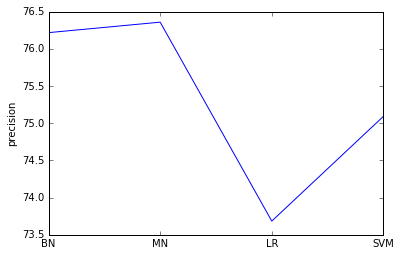

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
models_tags = ["BN", "MN", "LR", "SVM"]
perc = [76.2173, 76.3580, 73.6842, 75.0915]
plt.xticks(range(4), models_tags)
ax.plot(range(4), perc)
plt.ylabel("precision")
plt.show()

La información relevante corresponde a los indicadores entregados con la función de evaluación de los modelos y la presición de prueba, cada uno para cada modelo en su configuración óptima según los resultados obtenidos.

La tabla anterior muestra un resumen de todo el trabajo realizado y los mejores resultados obtenidos. El gráfico muestra una comparación de los porcentajes de precisión de cada modelo.

Finalmente, Multinomial Naive es el modelo que mejores resultados presenta para el conjunto de datos.